In [1]:
!pip3 install mne
!pip install POT
!git clone https://github.com/vpeterson/otda-mibci.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 79.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 18.3 MB/s eta 0:00:00
Cloning into 'otda-mibci'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 270 (delta 82), reused 87 (delta 36), pack-reused 120
Receiving objects: 100% (270/270), 82.39 MiB | 22.80 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [2]:
import numpy as np
import sys
sys.path.insert(1, 'otda-mibci')
from MIOTDAfunctions import*
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import mne
from mne.decoding import CSP
mne.set_log_level(verbose='warning') #to avoid info at terminal
from  random import sample
from sklearn.metrics import balanced_accuracy_score, accuracy_score
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
import ot

In [3]:
def Backward_GroupLasso_Transport(Gtr_daot, Ytr_daot, regu_, Gtr, Ytr, Gval, Yval, Gte, lda, metric):
      
    botda = ot.da.SinkhornL1l2Transport(metric=metric, reg_e=regu_[0], reg_cl=regu_[1])
    # learn params of transport
    botda.fit(Xs=Gval, ys=Yval, Xt=Gtr_daot)
    botda_matrix = botda.coupling_
    #transport testing samples
    transp_Xt_backward=botda.transform(Xs=Gte)
    botda_cost = botda.cost_
    
    # Compute accuracy without retraining    
    yt_predict = lda.predict(transp_Xt_backward) 
    
    return yt_predict, transp_Xt_backward, botda_matrix, botda_cost

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os.path as op
data_path = op.join('/content/drive/MyDrive/Proyecto_coadaptiveBCI/Simulaciones/simulated data/MI vs rest')

# Load training data - Session 1 - ERD 0.5

In [7]:
# %% Load Training data - session 1
Data_S1 = op.join(data_path, 'session1_epochs_epo.fif')
epochs_S1 = mne.read_epochs(Data_S1, preload=True, verbose=False)
# resample to 250 Hz
epochs_S1 = epochs_S1.resample(250)
epochs_S1_array = epochs_S1.get_data()  # Epoched data as a numpy array
# filter data between 8 an 30 hz
epochs_S1_array=mne.filter.filter_data(epochs_S1_array, 250, 8, 30)

ch_names = epochs_S1.ch_names  # Channels names

ERD = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]

# Train CSP + LDA decoder

In [8]:
#%% Training - Learn CSP+LDA from source data
Xtr = epochs_S1_array
Ytr = epochs_S1.events[:,2]
csp = CSP(n_components=2, reg='empirical', log=True, norm_trace=False, cov_est='epoch') #creating obj
#learn csp filters
Gtr = csp.fit_transform(Xtr, Ytr)
#learn lda
lda = LinearDiscriminantAnalysis()
lda.fit(Gtr,Ytr)
lda.score(Gtr,Ytr)

1.0

# Plot Training feautes

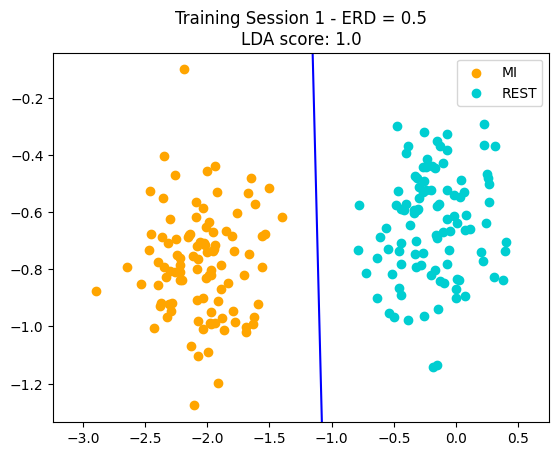

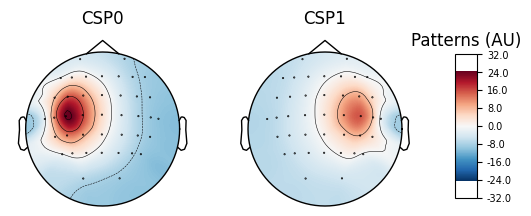

In [11]:
#Plot first 2 features
features = Gtr[:,0:2]
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='orange', label='MI')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='darkturquoise', label='REST')
axs.set_title("Training Session 1 - ERD = " + str(ERD[0]) + "\nLDA score: " + str(lda.score(Gtr,Ytr)))
axs.legend()
b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
xlim = xx
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue')
axs.set_ylim(ylim)

fig = csp.plot_patterns(epochs_S1.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

# Define BOTDA parameters

In [12]:
#%% OTDA parameters
rango_cl= [0.1, 1, 10]
rango_e= [0.1, 1, 10]
metric = 'sqeuclidean'
outerkfold = 20
innerkfold = None
M=20
norm=None
eps = 1e+6

Testing session  2


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in

[0.1, 1]


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)


the mean associated cost was: 11.232


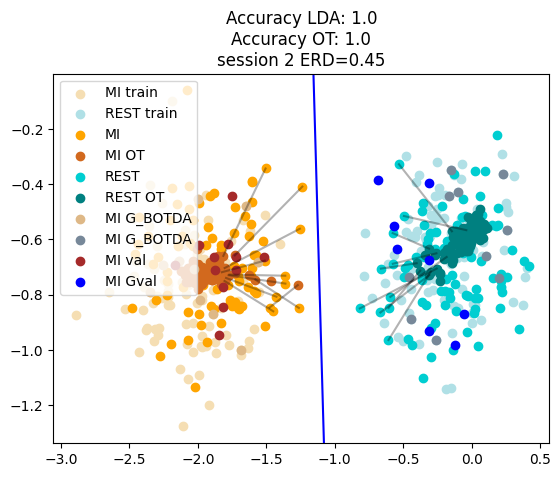

Testing session  3


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in

[0.1, 10]
the mean associated cost was: 10.118


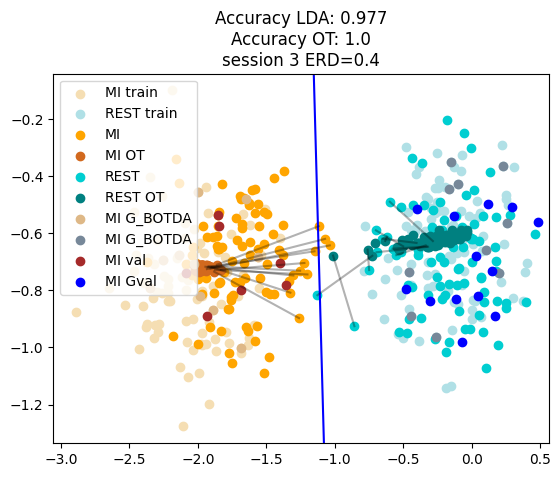

Testing session  4


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)


[0.1, 0.1]
the mean associated cost was: 9.091


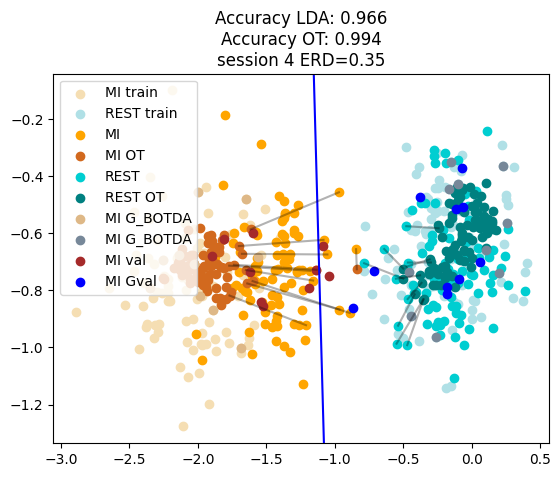

Testing session  5
[0.1, 1]
the mean associated cost was: 8.947


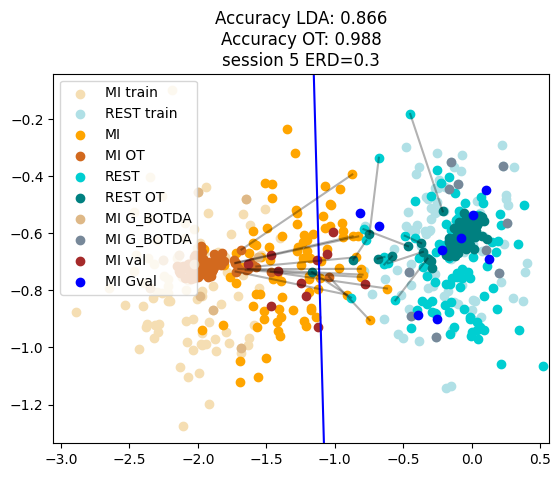

Testing session  6
[0.1, 10]
the mean associated cost was: 8.398


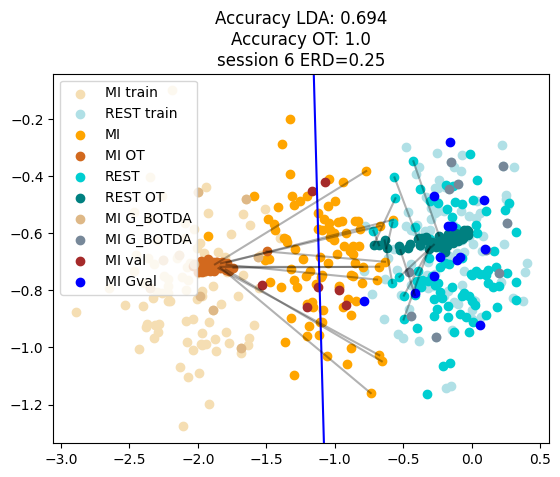

Testing session  7
[0.1, 10]
the mean associated cost was: 8.542


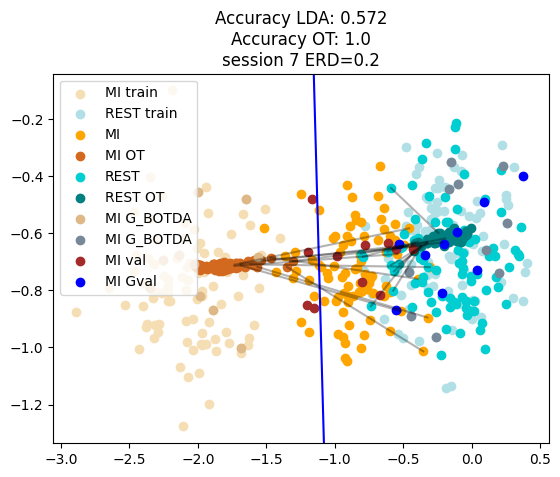

Testing session  8
[0.1, 10]
the mean associated cost was: 8.704


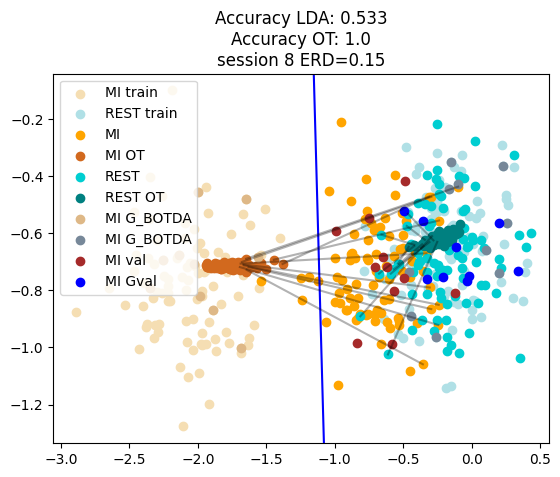

Testing session  9
[0.1, 10]
the mean associated cost was: 9.317


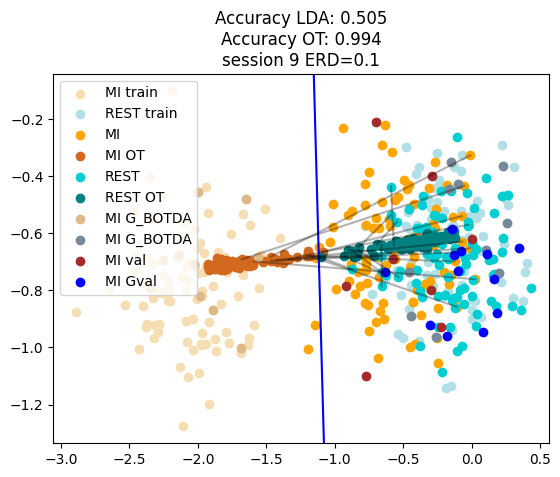

In [ ]:
# %% Test with sessions 
#data_path = op.join(root_path, 'simulated data\MI vs rest')
acc_lda = []
acc_OT = []
cost = []
regu = []
eu_distance = []
mean_dist = []

for i in range(2,10):
    print("Testing session ", i)

    Data_test = op.join(data_path, 'session' + str(i) +'_epochs_epo.fif')  
    epochs_test = mne.read_epochs(Data_test, preload=True, verbose=False)
    # resample to 250 Hz
    epochs_test = epochs_test.resample(250)
    epochs_test_array = epochs_test.get_data()  # Epoched data as a numpy array
    # Filter data 
    epochs_test_array=mne.filter.filter_data(epochs_test_array, 250, 8, 30)
    
    # i will split val and test data from here already to make the code more easy to follow
    Xte = epochs_test_array[20:].copy()  # Epoched data as a numpy array
    Yte = epochs_test.events[20:,2].copy()
    # use the first 20 samples for validation
    Xval = epochs_test_array[:20].copy()  # Epoched data as a numpy array
    Yval = epochs_test.events[:20,2].copy()

    # extract features
    Gte=csp.transform(Xte)
    Gval=csp.transform(Xval)

    y_predict_lda = lda.predict(Gte)
    acc_lda.append(accuracy_score(Yte,y_predict_lda))

    # OT
    y_predict_ot = []
    Transp = []
    associated_cost = []
    
    # select source subset
    G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_=\
    SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)
    print(regu_BOTDAl1l2_)
    regu.append(regu_BOTDAl1l2_[1])
    #initialize val set
    Xval_ = Xval.copy()
    Yval_ = Yval.copy()
    #  For each sample, make the data adaptation
    for re in range(1,len(Yte)+1):
        
        # testing trial
        Xte_=Xte[(re-1):(re)]
        Yte_=Yte[(re-1):(re)]
        
        Xval_=np.vstack((Xval_, Xte_))
        Yval_=np.hstack((Yval_, Yte_))
        
        # csp estimation
        Gval_=csp.transform(Xval_)
        Gte_=csp.transform(Xte_)
     
        y_pred_, transp_Xt_backward, botda_matrix, botda_cost = Backward_GroupLasso_Transport(G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_, Gtr, Ytr, Gval_, Yval_, Gte_, lda, metric)
        # save OT prediction
        y_predict_ot.append(y_pred_)
        # the cost would be associated to the last column of the cost matrix
        associated_cost.append(np.linalg.norm(botda_cost[-1,:]))
        eu_distance.append(np.linalg.norm(Gte_- transp_Xt_backward))
        # save transported data
        Transp.append(transp_Xt_backward)
      
    Gte_ot=np.squeeze(Transp)
    y_predict_ot = np.squeeze(y_predict_ot)
    
    acc_OT.append(accuracy_score(Yte,y_predict_ot))
    #print("the accuracy was: ")
    print("the mean associated cost was: %.3f" % np.mean(associated_cost))
    cost.append(np.mean(associated_cost))
    mean_dist.append(np.mean(eu_distance))
    #save data   
    #dic_path = op.join(result_path, 'Simulation2csp_session' + str(i) + '.npz')
    #np.savez(dic_path, G_BOTDAl1l2_=G_BOTDAl1l2_, Y_BOTDAl1l2_ = Y_BOTDAl1l2_, regu_BOTDAl1l2_ = regu_BOTDAl1l2_, botda_matrix=botda_matrix, y_tr = Yte, y_lda = y_lda, y_OT = yt_predict)
    
    #Plot first 2 features
    ft = Gte[:,0:2]
    ft_ot = Gte_ot[:,0:2]
    
    outernMI = np.argsort(ft[Yte==1, 0])[len(ft[Yte==1, 0])-10:]
    outernR = np.argsort(ft[Yte==2, 0])[0:10]
    
    x = np.linspace(-1,3,500)
    y = np.linspace(2,8,500)
    X,Y = np.meshgrid(x,y)
    pos = np.array([X.flatten(),Y.flatten()]).T
    fig, axs = plt.subplots()
    axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='wheat', label='MI train')
    axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='powderblue', label='REST train')   
    axs.scatter(ft[Yte==1, 0], ft[Yte==1, 1], c='orange', label='MI')   
    axs.scatter(ft_ot[Yte==1, 0], ft_ot[Yte==1, 1], c='chocolate', label='MI OT')    
    axs.scatter(ft[Yte==2, 0], ft[Yte==2, 1], c='darkturquoise', label='REST') 
    axs.scatter(ft_ot[Yte==2, 0], ft_ot[Yte==2, 1], c='teal', label='REST OT')

    axs.scatter(G_BOTDAl1l2_[Y_BOTDAl1l2_==1, 0], G_BOTDAl1l2_[Y_BOTDAl1l2_==1, 1], c='burlywood', label='MI G_BOTDA')
    axs.scatter(G_BOTDAl1l2_[Y_BOTDAl1l2_==2, 0], G_BOTDAl1l2_[Y_BOTDAl1l2_==2, 1], c='lightslategray', label='MI G_BOTDA')
    # i will plot the subset where the transport is learned
    axs.scatter(Gval[Yval==1, 0], Gval[Yval==1, 1], c='brown', label='MI val')
    axs.scatter(Gval[Yval==2, 0], Gval[Yval==2, 1], c='blue', label='MI Gval')
    axs.set_title('Accuracy LDA: ' + str(accuracy_score(Yte,y_predict_lda))[0:5] + 
                  '\nAccuracy OT: ' + str(accuracy_score(Yte,y_predict_ot))[0:5] + '\nsession ' + str(i) + ' ERD=' + str(ERD[i-1])
                  )               
    axs.legend(loc='upper left')        
    b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
    xx = np.array(axs.get_xlim())
    ylim = np.array(axs.get_ylim())
    axs.plot(xx, -(b+xx*w1)/w2, c='blue')
    axs.set_ylim(ylim)
    axs.set_xlim(xlim)
    plt.plot([ft[Yte==1, 0][outernMI],ft_ot[Yte==1, 0][outernMI]], [ft[Yte==1, 1][outernMI], ft_ot[Yte==1, 1][outernMI]],'k-', alpha = 0.3)  
    plt.plot([ft[Yte==2, 0][outernR],ft_ot[Yte==2, 0][outernR]], [ft[Yte==2, 1][outernR], ft_ot[Yte==2, 1][outernR]],'k-', alpha = 0.3)
    plt.show()




  Session    ERD    Acc    Acc with OT    mean assoc. cost    mean euclidean distance    regu param
---------  -----  -----  -------------  ------------------  -------------------------  ------------
        2   0.45   1              1               11.2318                    0.227733           1
        3   0.4    0.98           1               10.1182                    0.262517          10
        4   0.35   0.97           0.99             9.09116                   0.288173           0.1
        5   0.3    0.87           0.99             8.94664                   0.322127           1
        6   0.25   0.69           1                8.39762                   0.368973          10
        7   0.2    0.57           1                8.54217                   0.407175          10
        8   0.15   0.53           1                8.70358                   0.44132           10
        9   0.1    0.51           0.99             9.31737                   0.480751          10


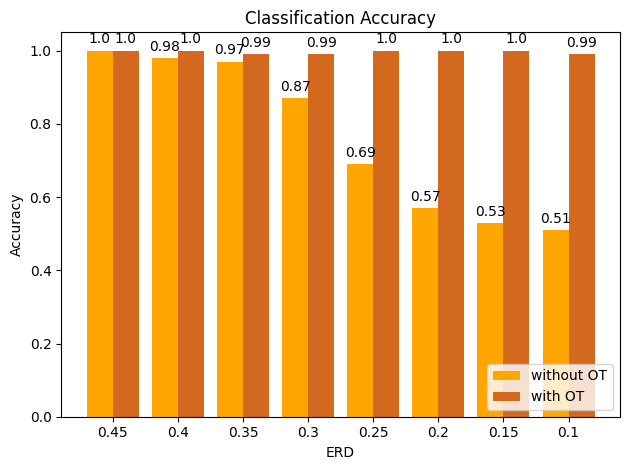

In [ ]:
# %%
from tabulate import tabulate
acc_lda = [round(item, 2) for item in acc_lda]
acc_OT = [round(item, 2) for item in acc_OT]
arr = np.arange(2,10,1)
info = {'Session': arr,
        'ERD' : np.array(ERD)[arr-1],
        'Acc': acc_lda, 
        'Acc with OT': acc_OT,
        'mean assoc. cost': cost,
        'mean euclidean distance': mean_dist,
        'regu param': regu}
table = tabulate(info, headers='keys')
print(table)
#with open(str(result_path +  '\AccuracyResult_OT.txt'), 'w') as f:
#f.write(table)

##
fig, axs = plt.subplots()
x = np.arange(len(arr))
bar1 = plt.bar(x-0.2, acc_lda, 0.4, color='orange', label='without OT')
bar2 = plt.bar(x+0.2, acc_OT, 0.4, color='chocolate', label='with OT')
plt.title('Classification Accuracy')
plt.xlabel("ERD")
plt.ylabel("Accuracy")
plt.xticks(x, np.array(ERD)[[arr-1]])
plt.legend(loc='lower right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3)[:4],  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bar1)
autolabel(bar2)
fig.tight_layout()
plt.show()
#plt.savefig(result_path + '\ACCURACY.svg')


In [ ]:
print(acc_lda)
print(acc_OT)


[1.0, 0.98, 0.97, 0.87, 0.69, 0.57, 0.53, 0.51]
[1.0, 1.0, 0.99, 0.99, 1.0, 1.0, 1.0, 0.99]


## Check KLD

In [ ]:
# KL Divergence

def dkls(mu_p,mu_q,sigma_p,sigma_q):
    k=len(mu_p)
    
    inv_sigma_p=np.linalg.inv(sigma_p)
    inv_sigma_q=np.linalg.inv(sigma_q)
    
    term0_a=(mu_p - mu_q).T
    term0_b=inv_sigma_p + inv_sigma_q
    term0_c=mu_p - mu_q
    term1 = term0_a @ term0_b @ term0_c
    
    term2= np.trace( inv_sigma_q @ sigma_p )
    
    term3=np.trace( inv_sigma_p @ sigma_q )
    
    D_kls =(term1 + term2+ term3  - 2*k)/4
    
    return D_kls


In [ ]:
### K-L DIVERGECY SCORE ###############################################
# np.mean, np.cov
# p = features train class 1 (MI)
# q = features test class 1 (MI)

# features train clase 1 (features[Ytr==1]) y features test clase 1 (for each test session) ---> Esperamos que crezca a medida que ERD disminuye
# features train clase 2 y features test clase 2 (for each test session) ---> Esperamos que crezca a medida que ERD disminuye
from tabulate import tabulate

for h in range(1,3):
  #print(h) #class
  ft_all = features #(200,2)
  ft_train_MI = ft_all[Ytr==h] #(100,2)
  mu_train = np.mean(ft_train_MI,0) #(2,) 
  sigma_train = np.cov(ft_train_MI.T) # (2,2)
  #print("group1: session 1, ERD = 0.5")
  D_kls_arr = []
  arr = np.array([1,2,3,4,5,6,7,8,9])
  for i in arr:
    #print(i)
    Data_test = op.join(data_path, 'session' + str(i) +'_epochs_epo.fif')  
    epochs_test = mne.read_epochs(Data_test, preload=True, verbose=False)
    epochs_test = epochs_test.resample(250) # resample to 250 Hz
    epochs_test_array = epochs_test.get_data()  # Epoched data as a numpy array
    epochs_test_array=mne.filter.filter_data(epochs_test_array, 250, 8, 30) # Filter data 
    Yte = epochs_test.events[:, 2]
    ft_test=csp.transform(epochs_test_array)
    ft_test_MI = ft_test[Yte==h]
    mu_test = np.mean(ft_test_MI,0)
    sigma_test = np.cov(ft_test_MI.T)
    D_kls = dkls(mu_train,mu_test,sigma_train,sigma_test)
    #print(D_kls)
    D_kls_arr.append(D_kls)

  D_kls_arr = [round(item, 2) for item in D_kls_arr]

  print('Train session: 1, Inter-session K-LD score for class ', h  )
  info = {'Test Session': arr,
          'ERD' : np.array(ERD)[arr-1],
          'KLD score': D_kls_arr}
  table = tabulate(info, headers='keys')
  print(table)

  plt.plot(arr, D_kls_arr)
  plt.xlabel("Test session")
  plt.ylabel("K-L Divergency score")
  plt.legend(['Class 1', 'Class 2'])

#plt.show()


Train session: 1, Inter-session K-LD score for class  1
  Test Session    ERD    KLD score
--------------  -----  -----------
             1   0.5          0
             2   0.45         0.38
             3   0.4          1.07
             4   0.35         3.13
             5   0.3          3.76
             6   0.25         7.28
             7   0.2         10.1
             8   0.15        13.18
             9   0.1         13.97
Train session: 1, Inter-session K-LD score for class  2
  Test Session    ERD    KLD score
--------------  -----  -----------
             1   0.5          0
             2   0.45         0.05
             3   0.4          0.06
             4   0.35         0.1
             5   0.3          0.12
             6   0.25         0.11
             7   0.2          0.05
             8   0.15         0.04
             9   0.1          0.13


Intra-session K-LD score for class 1 vs 2
  Session    ERD    KLD score
---------  -----  -----------
        1   0.5         23.42
        2   0.45        18.7
        3   0.4         15.1
        4   0.35        15.05
        5   0.3          8.8
        6   0.25         7.79
        7   0.2          3.5
        8   0.15         2.15
        9   0.1          1.05


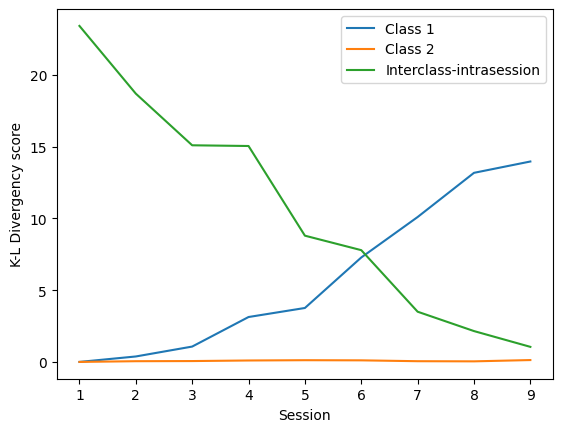

In [ ]:
# features test clase 1 y features test clase 2 (for each test session) ---> Esperamos un valor que disminuya a medida que ERD 
arr = np.array([1,2,3,4,5,6,7,8,9])
D_kls_arr_intra = []
for i in arr:
    #print(i)
    Data_test = op.join(data_path, 'session' + str(i) +'_epochs_epo.fif')  
    epochs_test = mne.read_epochs(Data_test, preload=True, verbose=False)
    # resample to 250 Hz
    epochs_test = epochs_test.resample(250)
    epochs_test_array = epochs_test.get_data()  # Epoched data as a numpy array
    # Filter data 
    epochs_test_array=mne.filter.filter_data(epochs_test_array, 250, 8, 30)
    Yte = epochs_test.events[:, 2]
    ft_test=csp.transform(epochs_test_array) #(200,2)

    ft_MI = ft_test[Yte==1] #(100,2)
    mu_MI = np.mean(ft_MI,0) #(2,) 
    sigma_MI = np.cov(ft_MI.T) # (2,2)

    ft_rest = ft_test[Yte==2] #(100,2)
    mu_rest = np.mean(ft_rest,0) #(2,) 
    sigma_rest = np.cov(ft_rest.T) # (2,2)

    D_kls = dkls(mu_MI,mu_rest,sigma_MI,sigma_rest)
    #print(D_kls)
    D_kls_arr_intra.append(D_kls)
D_kls_arr_intra = [round(item, 2) for item in D_kls_arr_intra]

print('Intra-session K-LD score for class 1 vs 2')
info = {'Session': arr,
        'ERD' : np.array(ERD)[arr-1],
        'KLD score': D_kls_arr_intra}
table = tabulate(info, headers='keys')
print(table)


plt.plot(arr, D_kls_arr_intra)
plt.legend(['Class 1', 'Class 2', 'Interclass-intrasession'])
plt.xlabel("Session")
plt.ylabel("K-L Divergency score")

plt.show()

1


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in

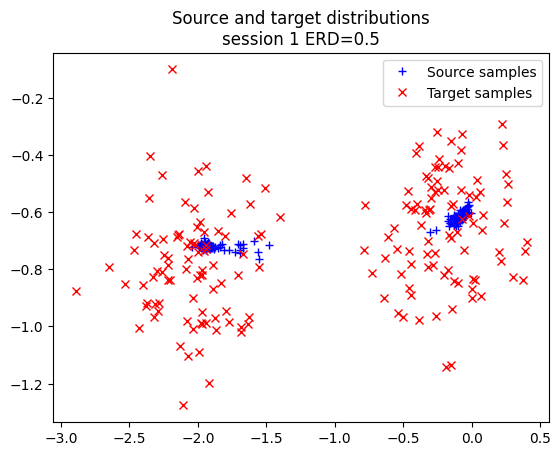

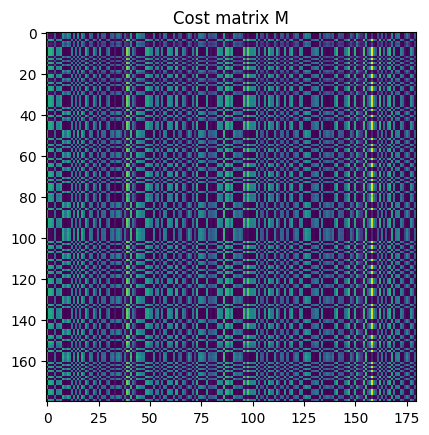

2


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in

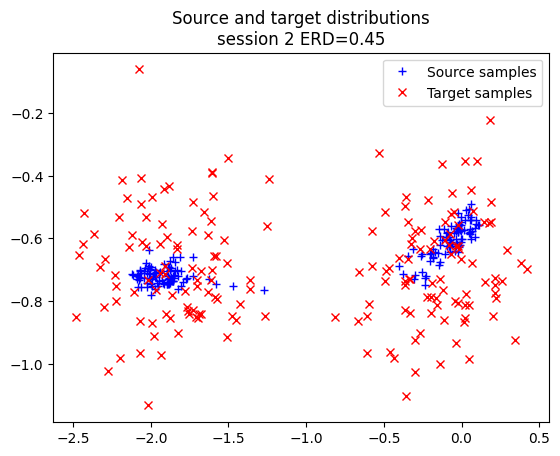

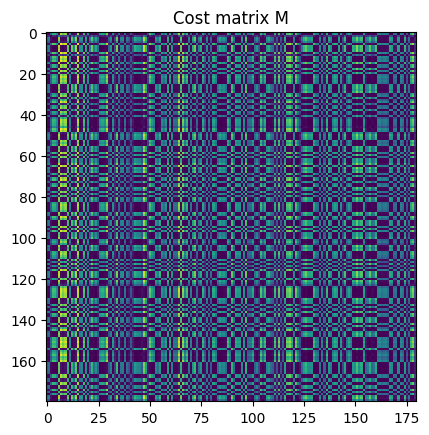

3


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in

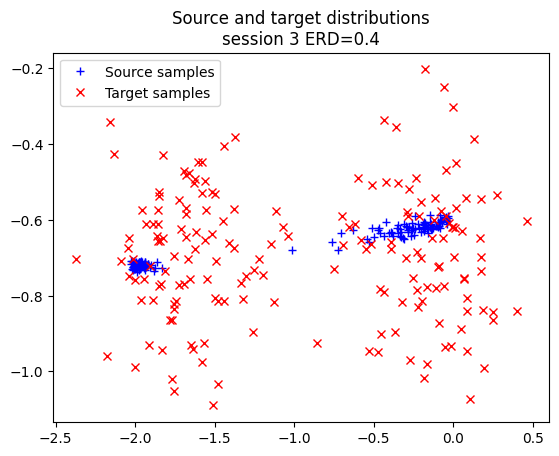

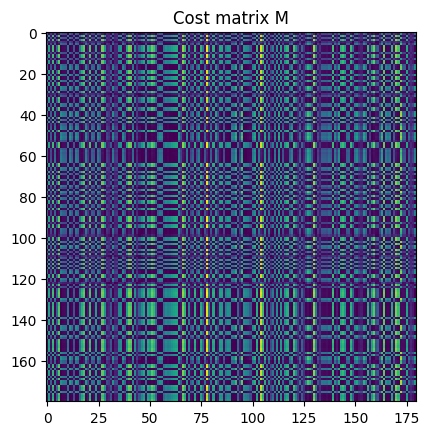

4


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)


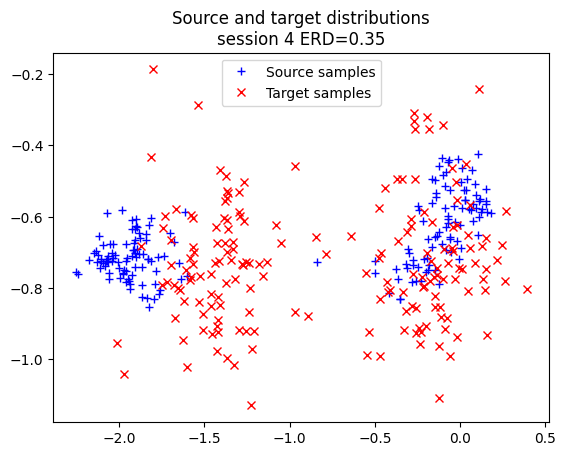

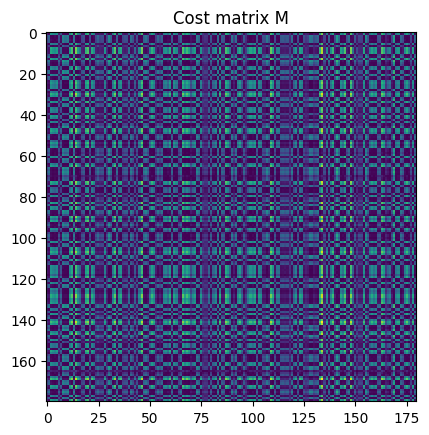

5


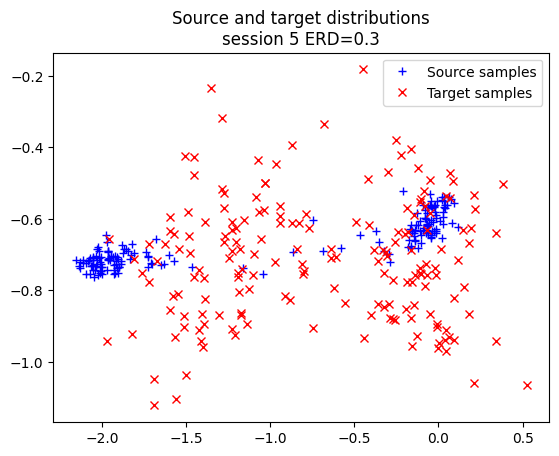

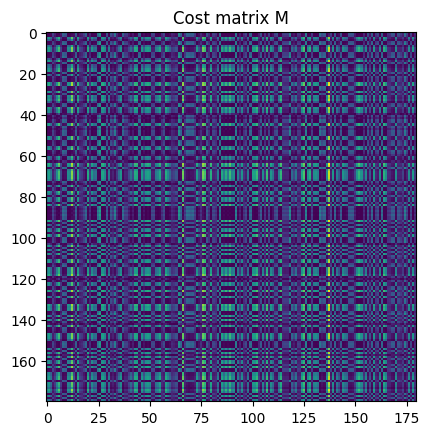

6


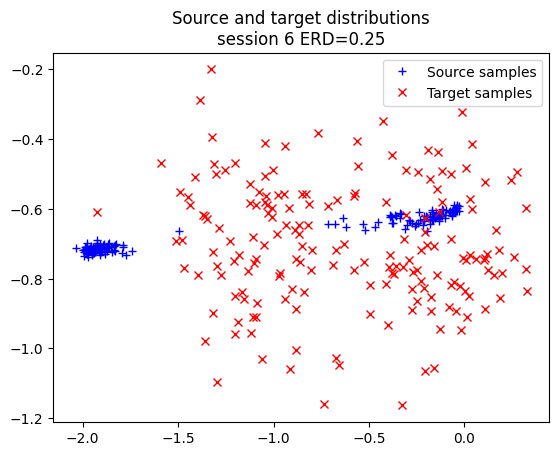

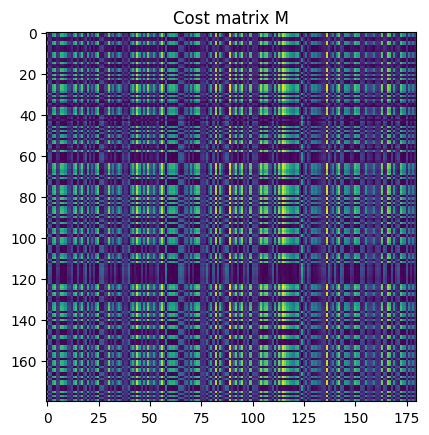

7


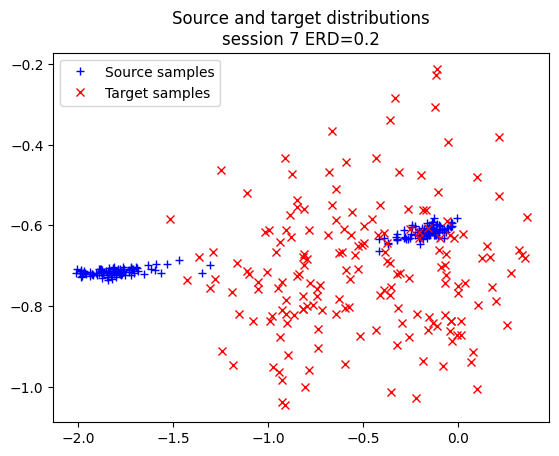

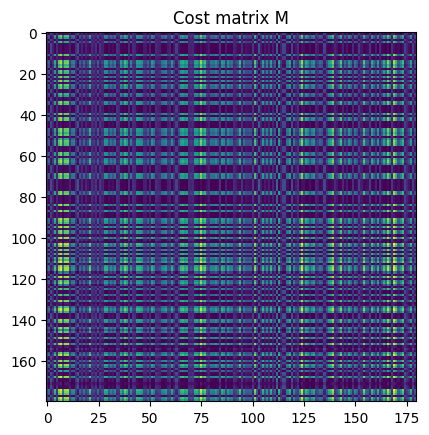

8


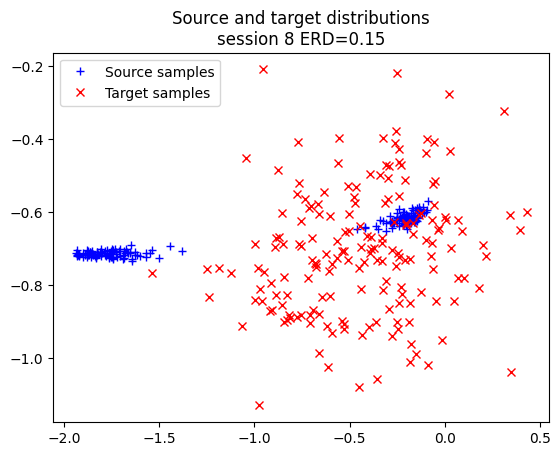

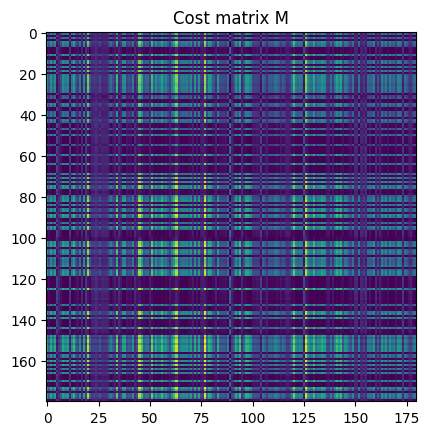

9


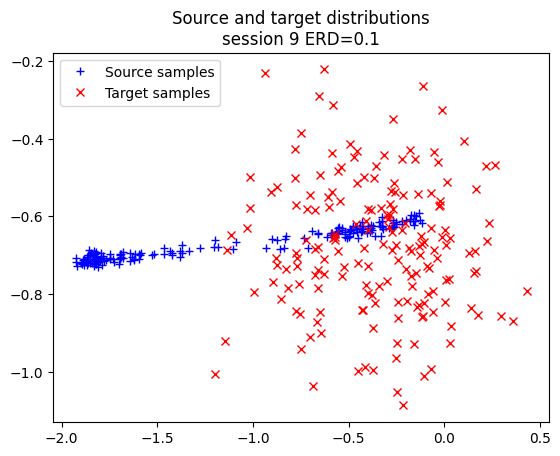

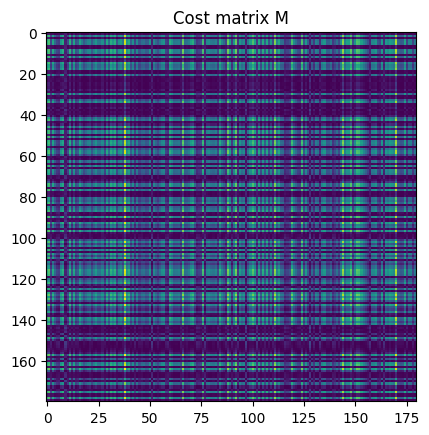

In [ ]:
#### Compute Wasserstein cost matrix ############
#M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
#M /= M.max()
#%% OTDA parameters

rango_cl=[0.1, 1, 10]
rango_e=[0.1, 1, 10] 
metric = 'sqeuclidean'
outerkfold = 20
innerkfold = None
M=20
norm=None
eps = 1e+6

acc_lda = []
acc_OT = []
arr = np.array([1,2,3,4,5,6,7,8,9])
for i in arr:
  print(i)
  Data_test = op.join(data_path, 'session' + str(i) +'_epochs_epo.fif')  
  epochs_test = mne.read_epochs(Data_test, preload=True, verbose=False)
  # resample to 250 Hz
  epochs_test = epochs_test.resample(250)
  epochs_test_array = epochs_test.get_data()  # Epoched data as a numpy array
  # Filter data 
  epochs_test_array=mne.filter.filter_data(epochs_test_array, 250, 8, 30)

  Xte = epochs_test_array  # Epoched data as a numpy array
  Yte = epochs_test.events[:,2]

  labels_te=Yte[20:].copy()
  Gte=csp.transform(Xte)
  y_lda = lda.predict(Gte)
  y_predict_lda = y_lda[20:].copy()
  acc_lda.append(accuracy_score(labels_te,y_predict_lda))

  #   OT
  yt_predict = []
  Transp = []

  # select source subset
  # Use the first 20 trials as the validation set
  Xval=Xte[0:20].copy()
  Yval=Yte[0:20].copy()

  ##
  Gval=csp.transform(Xval)

  # select source subset
  G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_=\
  SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)

  #  For each sample, make the data adaptation
  for re in range(1,len(labels_te)+1):
      
      #testing trial
      Xte_ot=Xte[20+(re-1):20+(re)]
      Yte_ot=Yte[20+(re-1):20+(re)]
      
      Xval=np.vstack((Xval, Xte_ot))
      Yval=np.hstack((Yval, Yte_ot))
      
      #csp estimation
      Gval=csp.transform(Xval)
      Gte_ot=csp.transform(Xte_ot)
    
      yt_pred, transp_Xt_backward, botda_matrix, botda_cost = Backward_GroupLasso_Transport(G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_, Gtr, Ytr, Gval, Yval, Gte_ot, lda, metric)
      yt_predict.append(yt_pred)
      #save transported data
      Transp.append(transp_Xt_backward)
    
  Gte_ot=np.squeeze(Transp)
  yt_predict = np.squeeze(yt_predict)
  acc_OT.append(accuracy_score(labels_te,yt_predict))


  xs = Gte_ot
  xt = Gte[20:]

  # loss matrix
  MM = ot.dist(xs, xt)
  MM /= MM.max()
  plt.figure(1)
  plt.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')              
  plt.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
  plt.legend(loc=0)
  plt.title('Source and target distributions' + '\nsession ' + str(i) + ' ERD=' + str(ERD[i-1]))

  plt.figure(2)
  plt.imshow(MM, interpolation='nearest')
  plt.title('Cost matrix M')
  plt.show()


1


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in

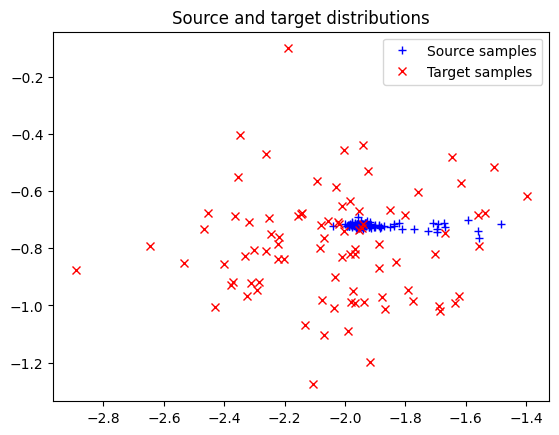

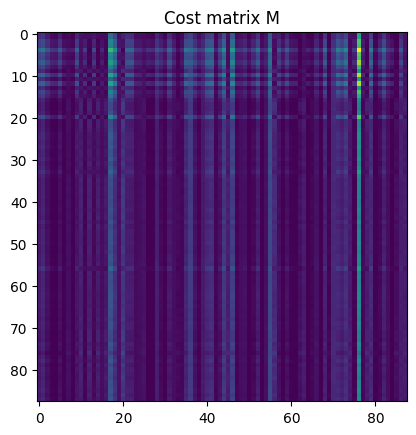

2


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in

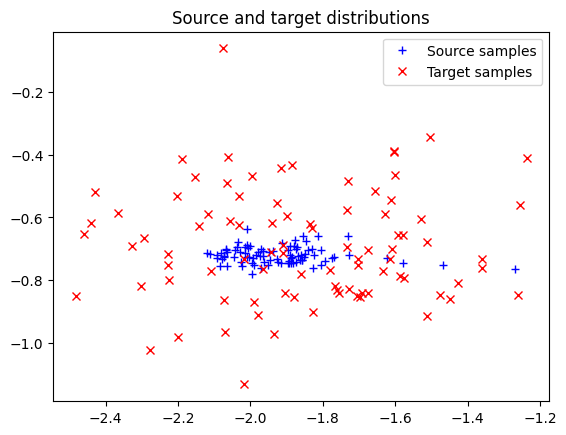

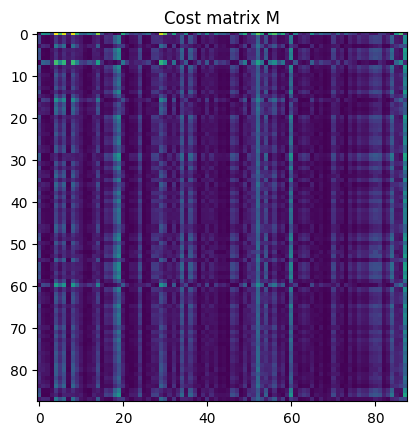

3


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in

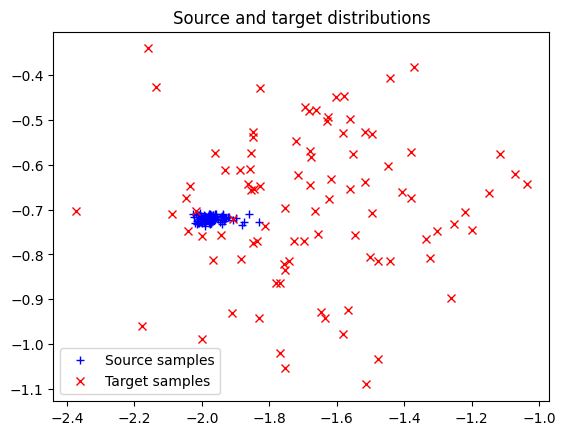

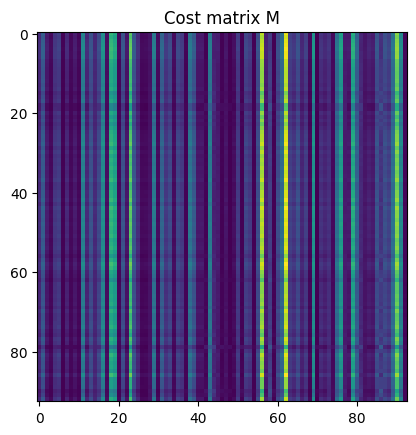

4


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:1040: RuntimeWarning: invalid value encountered in log
  return np.log(a)


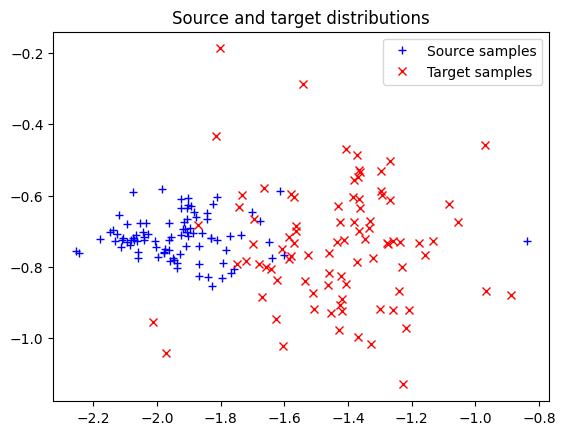

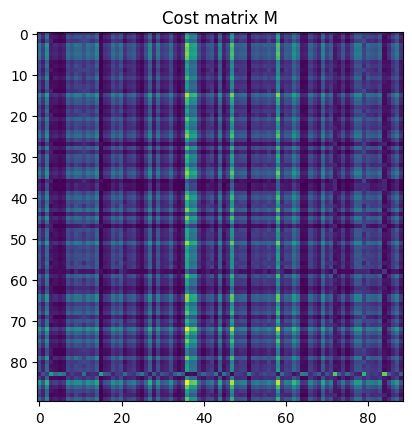

5


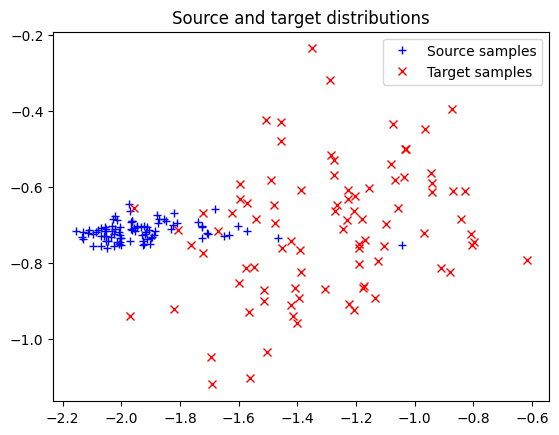

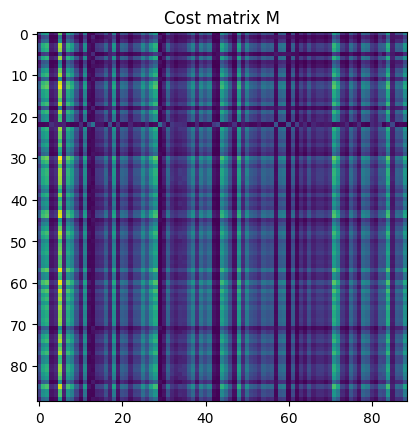

6


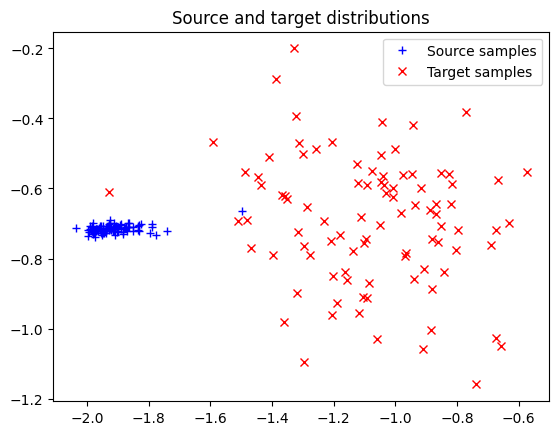

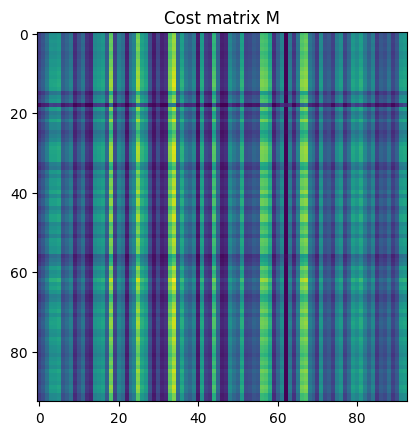

7


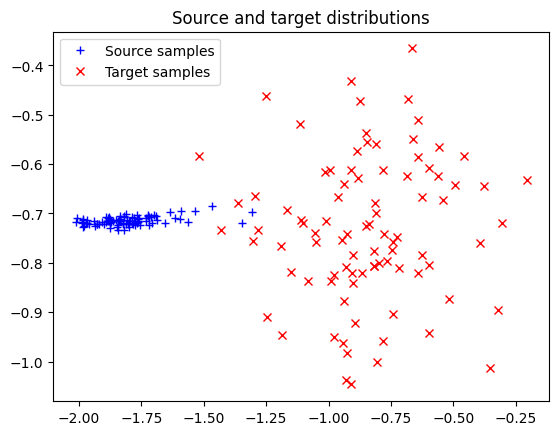

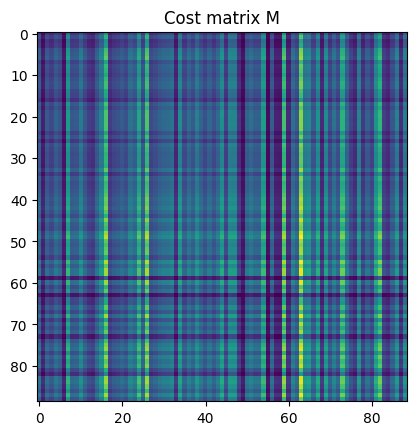

8


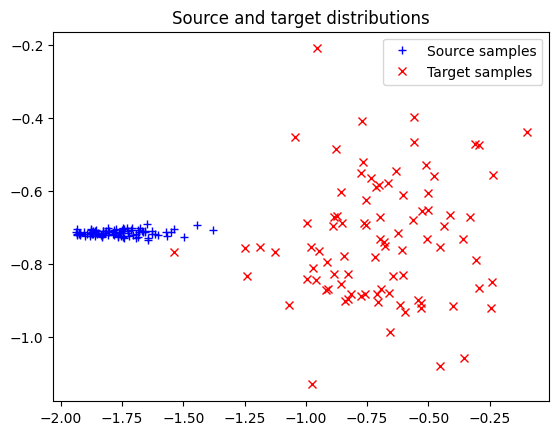

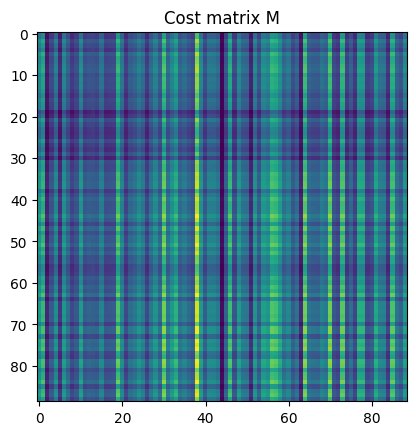

9


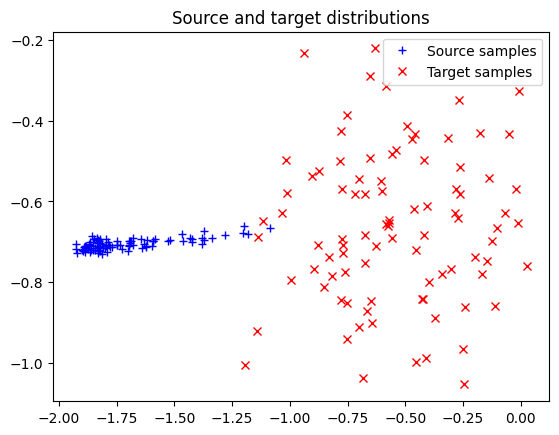

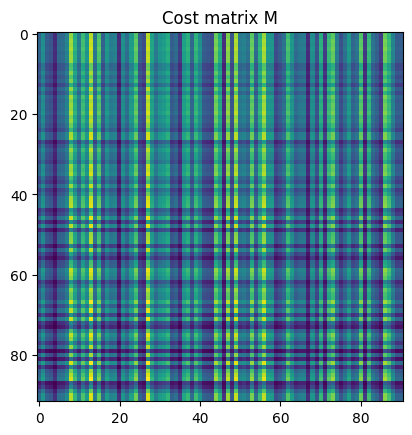

In [ ]:
rango_cl=[0.1, 1, 10]
rango_e=[0.1, 1, 10] 
metric = 'sqeuclidean'
outerkfold = 20
innerkfold = None
M=20
norm=None
eps = 1e+6

acc_lda = []
acc_OT = []
arr = np.array([1,2,3,4,5,6,7,8,9])

for i in arr:
  print(i)
  Data_test = op.join(data_path, 'session' + str(i) +'_epochs_epo.fif')  
  epochs_test = mne.read_epochs(Data_test, preload=True, verbose=False)
  # resample to 250 Hz
  epochs_test = epochs_test.resample(250)
  epochs_test_array = epochs_test.get_data()  # Epoched data as a numpy array
  # Filter data 
  epochs_test_array=mne.filter.filter_data(epochs_test_array, 250, 8, 30)

  Xte = epochs_test_array  # Epoched data as a numpy array
  Yte = epochs_test.events[:,2]

  labels_te=Yte[20:].copy()
  Gte=csp.transform(Xte)
  y_lda = lda.predict(Gte)
  y_predict_lda = y_lda[20:].copy()
  acc_lda.append(accuracy_score(labels_te,y_predict_lda))

  #   OT
  yt_predict = []
  Transp = []

  # select source subset
  # Use the first 20 trials as the validation set
  Xval=Xte[0:20].copy()
  Yval=Yte[0:20].copy()

  ##
  Gval=csp.transform(Xval)

  # select source subset
  G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_=\
  SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)

  #  For each sample, make the data adaptation
  for re in range(1,len(labels_te)+1):
      
      #testing trial
      Xte_ot=Xte[20+(re-1):20+(re)]
      Yte_ot=Yte[20+(re-1):20+(re)]
      
      Xval=np.vstack((Xval, Xte_ot))
      Yval=np.hstack((Yval, Yte_ot))
      
      #csp estimation
      Gval=csp.transform(Xval)
      Gte_ot=csp.transform(Xte_ot)
    
      yt_pred, transp_Xt_backward, botda_matrix, botda_cost = Backward_GroupLasso_Transport(G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_, Gtr, Ytr, Gval, Yval, Gte_ot, lda, metric)
      yt_predict.append(yt_pred)
      #save transported data
      Transp.append(transp_Xt_backward)
    
  Gte_ot=np.squeeze(Transp)
  yt_predict = np.squeeze(yt_predict)
  acc_OT.append(accuracy_score(labels_te,yt_predict))

  xs = Gte_ot[labels_te==1]
  xt = Gte[20:]
  xt = xt[yt_predict==1].copy()

  # loss matrix
  MM = ot.dist(xs, xt)
  #MM /= MM.max()
  plt.figure(1)
  plt.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
  plt.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
  plt.legend(loc=0)
  plt.title('Source and target distributions')

  plt.figure(2)
  plt.imshow(MM, interpolation='nearest')
  plt.title('Cost matrix M')
  plt.show()